In [238]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.models as vmodels
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import torchvision
import random
from PIL import Image
import Augmentor
import os
import json
torch.manual_seed(1)

USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### Image load 

In [3]:
image = Image.open('image_samples/Schnauzer.jpg')

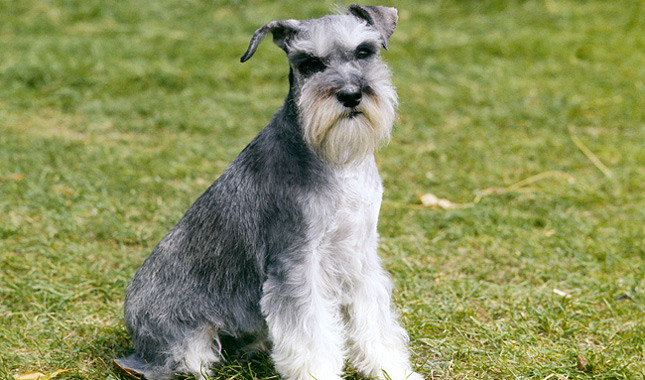

In [4]:
image

In [12]:
image.size # width, height

(645, 380)

### Crop : 부분만 잘라내기

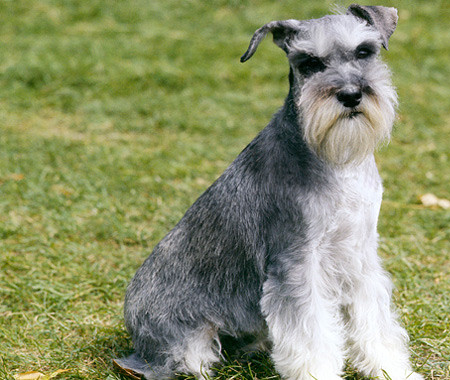

In [13]:
image.crop([0,0,450,380]) # x0,y0,x1,y1 left, top, right, bottom

### Resize : 사이즈 재조정 

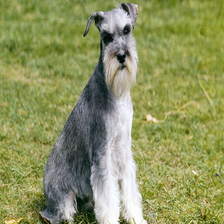

In [21]:
image.resize([224,224],Image.ANTIALIAS)

In [14]:
# https://github.com/yunjey/show-attend-and-tell/blob/master/resize.py
def resize_image(image):
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width
    image = image.crop((left, top, right, bottom))
    image = image.resize([224, 224], Image.ANTIALIAS)
    return image

In [15]:
resized_image = resize_image(image)

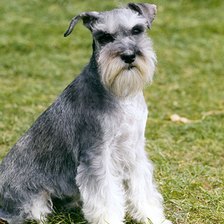

In [16]:
resized_image

### Rotation : 이미지 기울이기

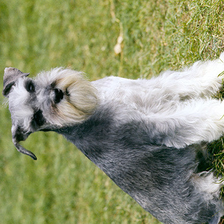

In [26]:
resized_image.rotate(90)

### Grey Scale 

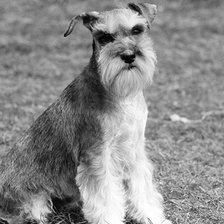

In [54]:
gray_scaled = resized_image.convert("L")
gray_scaled

### Normalize 

In [183]:
totensor = transforms.ToTensor()
topil = transforms.ToPILImage()

In [181]:
totensor(resized_image)


( 0 ,.,.) = 
  0.5569  0.5608  0.5333  ...   0.4275  0.4510  0.4627
  0.5765  0.5647  0.5569  ...   0.4392  0.4784  0.4667
  0.5725  0.5647  0.5804  ...   0.4784  0.4824  0.4784
           ...             ⋱             ...          
  0.4314  0.3529  0.1176  ...   0.8078  0.7176  0.4706
  0.1412  0.3608  0.4784  ...   0.5373  0.4314  0.5176
  0.0471  0.1020  0.1686  ...   0.4627  0.5490  0.6392

( 1 ,.,.) = 
  0.5922  0.5961  0.5804  ...   0.4980  0.5059  0.5059
  0.6157  0.6039  0.6039  ...   0.4863  0.5255  0.5333
  0.6157  0.6039  0.6275  ...   0.5137  0.5294  0.5529
           ...             ⋱             ...          
  0.3451  0.2706  0.1059  ...   0.6824  0.6902  0.5608
  0.1451  0.2824  0.3804  ...   0.4353  0.4353  0.5608
  0.1059  0.1333  0.1412  ...   0.4667  0.5529  0.6275

( 2 ,.,.) = 
  0.3490  0.3804  0.3647  ...   0.1804  0.2039  0.2039
  0.3765  0.3843  0.3882  ...   0.1490  0.2078  0.2353
  0.3804  0.3725  0.3961  ...   0.1647  0.2118  0.2667
           ...         

In [184]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # RGB
                                     std=[0.229, 0.224, 0.225])

# 전처리 파이프라인
# 텐서로 바꾸고, 노멀라이즈
preprosessing = transforms.Compose([
            transforms.ToTensor(),
           normalize,
        ])

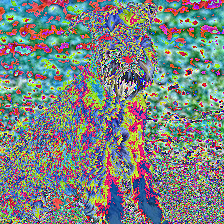

In [185]:
topil(preprosessing(resized_image))

## Augmentor 

In [189]:
p = Augmentor.Pipeline("image_samples/")
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

Initialised with 4 image(s) found.
Output directory set to image_samples/output.

In [190]:
p.sample(100) # data augmentation!

In [215]:
samples = os.listdir('image_samples/output/')

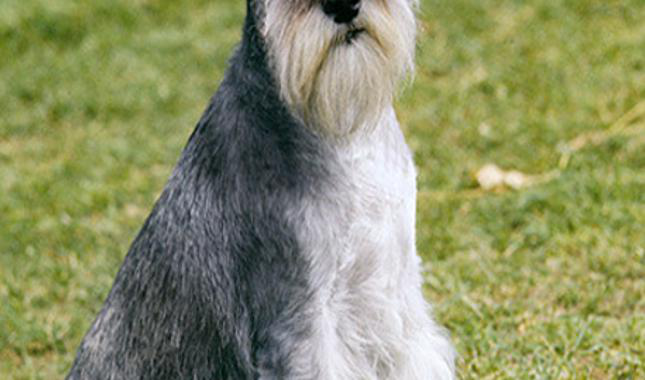

In [225]:
i = random.choice(range(100))
Image.open('image_samples/output/'+samples[i])

## Image data pipeline 

In [272]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

p = Augmentor.Pipeline()
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)


# 폴더 기준으로 image classification 데이터셋 파이프라인 구축
train_dataset = vdatasets.ImageFolder(
        "../../data/catdog/train/",
        transforms.Compose([
            p.torch_transform(), # Augmentor를 pytorch transform 파이프라인과 함께 사용 가능
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=2)

In [276]:
train_dataset[0]

(
 ( 0 ,.,.) = 
  -0.7822 -1.0904 -1.2959  ...  -0.4739 -0.4397 -0.4397
  -0.6623 -0.9705 -1.2274  ...  -0.3369 -0.3027 -0.2856
  -0.6623 -0.9705 -1.2617  ...  -0.1999 -0.1657 -0.1486
            ...             ⋱             ...          
  -1.7754 -1.7583 -1.7240  ...  -0.9192 -0.9534 -1.0733
  -1.7925 -1.7583 -1.7240  ...  -0.8678 -0.9534 -1.0733
  -1.7925 -1.7583 -1.7240  ...  -0.9363 -0.9877 -1.0390
 
 ( 1 ,.,.) = 
  -0.5476 -0.8627 -1.0728  ...  -0.7577 -0.7227 -0.7227
  -0.4251 -0.7402 -1.0028  ...  -0.6176 -0.5826 -0.5651
  -0.4251 -0.7402 -1.0378  ...  -0.4951 -0.4601 -0.4251
            ...             ⋱             ...          
  -1.6856 -1.6856 -1.6681  ...  -1.0728 -1.1078 -1.2304
  -1.7031 -1.6856 -1.6681  ...  -1.0203 -1.1078 -1.2304
  -1.7206 -1.7031 -1.6681  ...  -1.0903 -1.1429 -1.1954
 
 ( 2 ,.,.) = 
  -0.2184 -0.5321 -0.7413  ...  -0.4275 -0.3927 -0.3927
  -0.0964 -0.4101 -0.6715  ...  -0.2881 -0.2532 -0.2358
  -0.0964 -0.4101 -0.7064  ...  -0.1835 -0.1487 -0.1138


In [277]:
print(train_dataset.class_to_idx)
print(len(train_dataset.imgs))

{'cat': 0, 'dog': 1}
2000
